In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from tensorflow.keras import layers, losses, Sequential
from tensorflow.keras.models import Model
from keras.layers import Input, Dense
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%run model_toolkit.py
discretizer = Discretizer()
df = load_dataset('datasets/no_noise_circle_diameter500-10000_distance30-60_b0-3/*.npy')
df

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4095,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4096,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4097,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.999999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4098,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


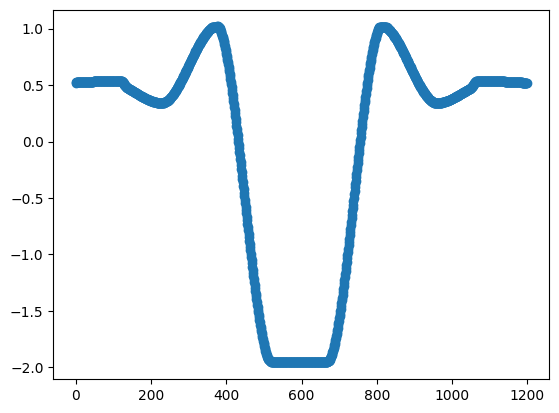

In [4]:
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

timeseries = []
invalid = []

for index, row in df.iterrows():
    scaler=StandardScaler()
    timeserie=interpolate.PchipInterpolator(np.arange(start=0, stop=92, step=1), row)(np.linspace(0,92,1000))
    timeserie=timeserie[abs(timeserie-1)>0.001]
    if len(timeserie) != 0:
        timeserie=interpolate.PchipInterpolator(np.arange(start=0, stop=len(timeserie), step=1), timeserie)(np.linspace(0,len(timeserie),1200))
        timeserie=scaler.fit_transform(timeserie.reshape(-1, 1))
        timeseries.append(timeserie)
    else:
        invalid.append(index)

timeseries = np.array(timeseries)
plt.plot(timeseries[0], 'o')

In [79]:
timeseries.shape

(4087, 1200, 1)

In [64]:
invalid

[65, 336, 340, 798, 1112, 1756, 2028, 2147, 2342, 2801, 3486, 3849, 3941]

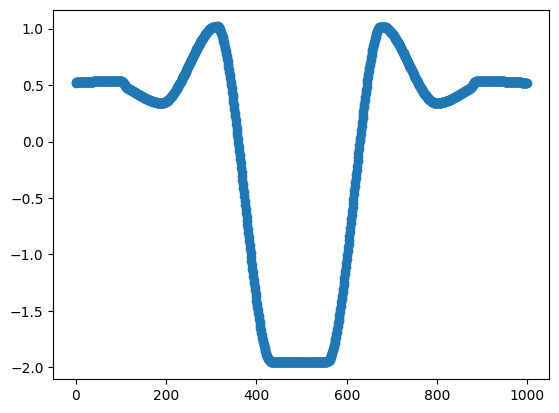

In [5]:
timeserie=interpolate.PchipInterpolator(np.arange(start=0, stop=len(timeseries[0]), step=1), timeseries[0])(np.linspace(0,len(timeseries[0]),1000))
plt.plot(timeserie, 'o');

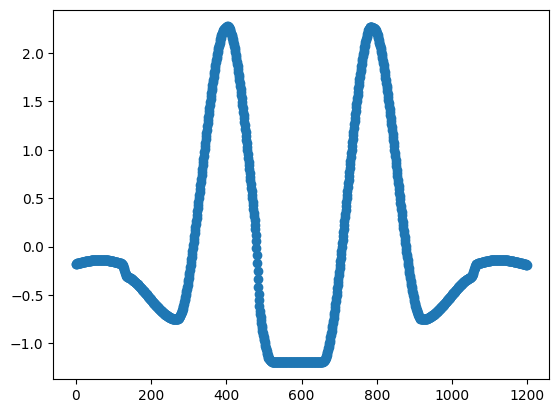

In [6]:
plt.plot(timeseries[7], 'o');

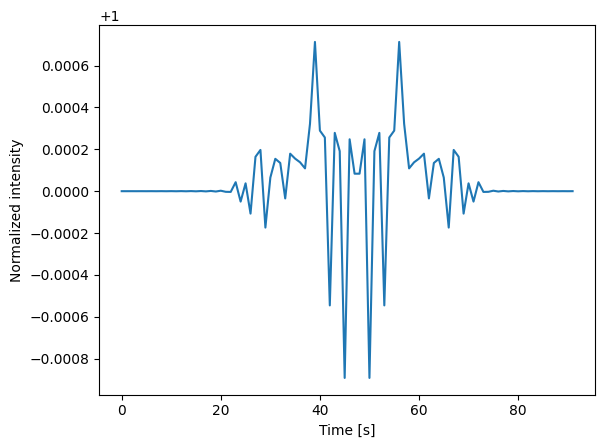

In [7]:
plt.xlabel('Time [s]')
plt.ylabel('Normalized intensity')
df.loc[invalid[7]].plot();

In [ ]:
occultation_features = discretizer.discretize_occultation_features('datasets/no_noise_circle_diameter500-10000_distance30-60_b0-3/taosii_circle_simulation_features.csv')
occultation_features[7]

In [6]:
occultation_features.groupby(['diameter']).count()

,distance,impact_parameter
diameter,,
0.0,615,615
1.0,820,820
2.0,820,820
3.0,820,820
4.0,1025,1025


In [7]:
occultation_features.groupby(['distance']).count()

,diameter,impact_parameter
distance,,
1.0,820,820
2.0,3280,3280


In [8]:
occultation_features.groupby(['impact_parameter']).count()

,diameter,distance
impact_parameter,,
0.0,300,300
1.0,200,200
2.0,300,300
3.0,3300,3300


In [ ]:
wandb.init(
    project="taos_ii_occultation_detector",
    config={
        'epochs': 1000, 
        'batch_size': 128,
        'learning_rate': 0.005,
        'loss_function': 'sparse_categorical_crossentropy',
        'architecture': 'cnn from paper',
        'leaky_relu_alpha': 0.1,
        'dataset': 'no_noise_circle_diameter500-10000_distance30-60_b0-3_standard_normalized_with_interpolation'
    }
)


config = wandb.config
    
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, ReLU, LeakyReLU, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.layers import LeakyReLU
import math

def get_model(n_inputs, filters=(64, 64, 64), kernel_size=3, dropout_rate=0.5):
    input_layer = Input(shape=(n_inputs,1))
    x = input_layer
    for f in filters:
        x = Conv1D(f, kernel_size, kernel_initializer='he_uniform', padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=config['leaky_relu_alpha'])(x)

    gap = GlobalAveragePooling1D()(x)
    
    out_x = Dense(5, activation='softmax', name='out_diameter', kernel_regularizer='l2')(gap)
    out_y = Dense(3, activation='softmax', name='out_distance', kernel_regularizer='l2')(gap) 
    out_z = Dense(4, activation='softmax', name='out_impact_parameter', kernel_regularizer='l2')(gap)
    
    model = Model(inputs=input_layer, outputs=[out_x, out_y, out_z])
    
    optimizer = Adam(config.learning_rate)
    
    def lr_scheduler(epoch, lr):
        decay_rate = 0.8
        decay_step = 1
        if epoch % decay_step == 0 and epoch:
            return lr * math.pow(decay_rate, epoch)
        return lr
    
    callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]
    
    model.compile(optimizer=optimizer, 
                  loss={'out_diameter': config.loss_function, 
                        'out_distance': config.loss_function,
                        'out_impact_parameter': config.loss_function},
                  metrics=['accuracy'])
    
    return model, callbacks


def evaluate_model(X, y):
 n_inputs = X.shape[1]
 cv = RepeatedKFold(n_splits=10, n_repeats=3)
 best_metric = float('inf')
 best_model_path = 'checkpoints/model_classification.keras'
 for train_ix, test_ix in cv.split(X):
     X_train, X_test = X[train_ix], X[test_ix]
        
     y_train_diameter, y_train_ua, y_train_b = y.iloc[train_ix, 0], y.iloc[train_ix, 1], y.iloc[train_ix, 2]
     y_test_diameter, y_test_ua, y_test_b = y.iloc[test_ix, 0], y.iloc[test_ix, 1], y.iloc[test_ix, 2]
     
     model, checkpoints = get_model(n_inputs)
     checkpoint_callback = ModelCheckpoint(
        best_model_path, 
        monitor='val_loss', 
        save_best_only=True, 
        mode='min', 
        verbose=0
     )
     tensorboard_callback = TensorBoard(log_dir='./logs/experiment2')
     wandb_callback = WandbCallback(log_weights=True)
    
     model.fit(
         tf.convert_to_tensor(X_train),
         [tf.convert_to_tensor(y_train_diameter), tf.convert_to_tensor(y_train_ua), tf.convert_to_tensor(y_train_b)], 
         verbose=0,
         batch_size=config.batch_size,
         epochs=config.epochs,
         callbacks=[checkpoints, tensorboard_callback, wandb_callback]
     )
        
     current_mae = model.evaluate(
            tf.convert_to_tensor(X_test), 
            [tf.convert_to_tensor(y_test_diameter), tf.convert_to_tensor(y_test_ua), tf.convert_to_tensor(y_test_b)], 
            verbose=0
     )
     
     avg_mae = sum(current_mae) / len(current_mae)
    
     if avg_mae < best_metric:
        best_metric = avg_mae
        model.save(best_model_path) 

evaluate_model(timeseries,occultation_features)

wandb: Currently logged in as: sanchezcarlosjr (unam-ia). Use `wandb login --relogin` to force relogin


2023-10-24 22:34:21.724472: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.



Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.

Epoch 2: LearningRateScheduler setting learning rate to 0.003999999910593033.

Epoch 3: LearningRateScheduler setting learning rate to 0.002559999823570252.

Epoch 4: LearningRateScheduler setting learning rate to 0.001310719966888428.

Epoch 5: LearningRateScheduler setting learning rate to 0.0005368709087371827.

Epoch 6: LearningRateScheduler setting learning rate to 0.00017592185974121097.

Epoch 7: LearningRateScheduler setting learning rate to 4.6116859436035173e-05.

Epoch 8: LearningRateScheduler setting learning rate to 9.671406555175785e-06.

Epoch 9: LearningRateScheduler setting learning rate to 1.6225927734375009e-06.

Epoch 10: LearningRateScheduler setting learning rate to 2.1778071594238292e-07.

Epoch 11: LearningRateScheduler setting learning rate to 2.3384025573730482e-08.

Epoch 12: LearningRateScheduler setting learning rate to 2.008672485351564e-09.

Epoch 13: LearningRateScheduler set

2023-10-12 10:23:49.584353: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<module 'matplotlib.pyplot' from '/h1/cesanchez/.conda/envs/py39/lib/python3.10/site-packages/matplotlib/pyplot.py'>

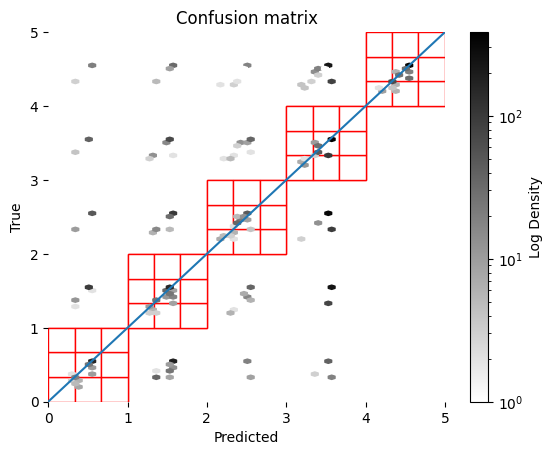

In [9]:
%run model_toolkit.py

plt = log_results('datasets/taosii_circle_simulation_features.csv', 'datasets/*.npy');
#wandb.log({"confusion_matrix_results": wandb.Image(plt, caption="Confusion matrix")})
plt